In [1]:
import numpy as np 
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt 
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import os
import shutil
from tensorflow.keras import metrics
import matplotlib
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop
plt.style.use('seaborn')


# Create X and y Data: Helper Functions

* create_X_and_y()

In [2]:
def create_X_and_y(X_filepath, y_filepath):
    
    ''' imports lined images and unlined images from jpeg files 
    into numpy arrays for use into autoencoder'''
    
    y_list = []
    for image in sorted(os.listdir(y_filepath)):
        file= y_filepath + str(image)
        y_image = np.array(Image.open(file))
        y_image = y_image.reshape(*y_image.shape,1)
        y_list.append(y_image)
                    
    y = np.array(y_list)  

    X_list = []
    for image in sorted(os.listdir(X_filepath)):
        file = X_filepath+str(image)
        X_image = np.array(Image.open(file))
        X_image = X_image.reshape(*X_image.shape,1)
        X_list.append(X_image)
        
    X = np.array(X_list)
    
    return X,y

# Model Setup: Helper Functions
* model:
    create_and_compile()
    fit_model()
    predict()
    
* plot:
    plot_loss()
    plot_accuracy()


In [3]:
def callbacks(model_name = 'model', early_stopping = False, patience = None):
    checkpoint_filepath = (f'./tmp/{model_name}/checkpoint')
    tensorboard = TensorBoard(log_dir=(f"./logs/{model_name}"),
                            
                            histogram_freq=2,
                            write_graph=True,
                            write_images=True,
                            update_freq="epoch",
                            profile_batch=2,
                            embeddings_freq=0,
                            embeddings_metadata=None)
    if early_stopping == True:
        early_stopping = EarlyStopping(monitor='loss',  patience=patience, restore_best_weights=True)
    model_cp = ModelCheckpoint(filepath=checkpoint_filepath, monitor = 'loss', save_best_only=True)
    
    return tensorboard, early_stopping, model_cp



In [4]:
def create_and_compile_sparse_model(optimizer='adam', learning_rate=.001, loss='mse', metrics='accuracy'):
    ''' creates and compiles model '''
    
    input_img = Input(shape=(500,400,1)) 
    x = Conv2D(32, (3, 3), activation='relu')(input_img)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = Dense(128)(x) 
    x= Conv2DTranspose(32,(3,3), activation='relu')(x)
    decoded = Conv2DTranspose(1, (3, 3), activation='linear', padding='same')(x)

    compile_optimizer = Adam(learning_rate=learning_rate)#if ever use different than Adam will need to change this line
    autoencoder = Model(input_img, decoded)
    autoencoder.summary()
    autoencoder.compile(optimizer=compile_optimizer, loss=loss, metrics=metrics)
    return autoencoder

In [5]:
def fit_model(compiled_model, x=X, y=y, batch_size=15, epochs=50, verbose=1, callbacks=None, validation_split=0.2):

    history = compiled_model.fit(x=X, y=y, batch_size=batch_size, epochs = epochs, verbose=verbose, callbacks=callbacks, validation_split=validation_split)
    return history

NameError: name 'X' is not defined

In [6]:
def plot_loss(model_name, model_history, metric_1 = 'loss', color_1='blue', metric_1_label = 'Training Loss Score by Epoch', 
                 metric_2 = 'val_loss', color_2='green', metric_2_label = 'Validation Loss Score by Epoch'):
    
    plt.plot(model_history.history[metric_1], color=color_1, label=metric_1_label)
    plt.plot(model_history.history[metric_2], color=color_2, label=metric_2_label)
    plt.title(label=model_name)
    plt.legend()


In [7]:
def plot_accuracy(model_name, model_history, metric_3 = 'accuracy', color_3='red', metric_3_label = 'Training Accuracy Score by Epoch', 
                 metric_4 = 'val_accuracy', color_4='orange', metric_4_label = 'Validation Accuracy Score by Epoch'):
    
    plt.plot(model_history.history[metric_3], color=color_3, label=metric_3_label)
    plt.plot(model_history.history[metric_4], color=color_4, label=metric_4_label)
    plt.title(label=model_name)
    plt.legend()

In [8]:
def predict_image_on_X(fitted_model, X=X, index=0):
    result = fitted_model.predict(X)
    result[result>255]=255
    result[result<0] = 0
    result = result[index].astype(np.uint8).reshape(500,400)
    original = X[index].astype(np.uint8).reshape(500,400)
    
    return Image.fromarray(np.hstack([original, result]))

NameError: name 'X' is not defined

In [9]:
def predict_on_unseen(fitted_model, file_path_list):
    
    '''Removes the lines on images that the model has NOT seen. To see the images index into list that is returned.''' 
    
    
    if len(file_path_list)== 1:
        image_to_predict = np.array(Image.open(str(file_path_list)))
        result = fitted_model.predict(np.array([image_to_predict.reshape(*image_to_predict.shape, 1)]))
        result[result>255]=255
        result[result<0] = 0
        result = result.astype(np.uint8).reshape(500,400)
        return Image.fromarray(np.hstack([image_to_predict, result]))
                                    
    else:
        original_image_list = []
        result_image_list = []
        for idx, original_image in enumerate(file_path_list):
            original_image = np.array(Image.open(str(file_path_list[idx])))
            original_image_list.append(original_image)
                                      
            result = fitted_model.predict(np.array([original_image.reshape(*original_image.shape, 1)]))
            result[result>255]=255
            result[result<0] = 0
            result = result.astype(np.uint8).reshape(500,400)
            result_image_list.append(result)
        
        all_results_list=[]
        for idx, images in enumerate(zip(original_image_list, result_image_list)):
            all_results_list.append(Image.fromarray(np.hstack([original_image_list[idx], result_image_list[idx]])))
        return all_results_list


# The Models w/ Results

In [10]:
'''Create the data X,y '''
y_filepath = 'Data/y_variables/Unruled/'
X_filepath = 'Data/X_variables/computer_generated_lines/'

X,y = create_X_and_y(X_filepath, y_filepath)
X.shape, y.shape

((669, 500, 400, 1), (669, 500, 400, 1))

### Model: Sparse #1


In [122]:
tensorboard, early_stopping, model_cp = callbacks(model_name = 'sparse_1', early_stopping = True, patience = 20)
sparse_1 = create_and_compile_sparse_model(optimizer='adam', loss='mse', metrics='accuracy')

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 500, 400, 1)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 498, 398, 32)      320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 498, 398, 8)       2312      
_________________________________________________________________
dense_3 (Dense)              (None, 498, 398, 128)     1152      
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 500, 400, 32)      36896     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 500, 400, 1)       289       
Total params: 40,969
Trainable params: 40,969
Non-trainable params: 0
__________________________________________________

In [123]:
sparse_1_history = fit_model(sparse_1, x=X, y=y, batch_size=15, epochs=500, 
                             verbose=1, callbacks=[tensorboard,model_cp], validation_split=0.2)




Epoch 1/500
36/36 [==============================] - 4s 110ms/step - loss: 4492.1787 - accuracy: 4.2523e-06 - val_loss: 509.4282 - val_accuracy: 9.7388e-06
Epoch 2/500
36/36 [==============================] - 4s 104ms/step - loss: 379.3084 - accuracy: 4.2617e-06 - val_loss: 278.3251 - val_accuracy: 9.7388e-06
Epoch 3/500
36/36 [==============================] - 4s 104ms/step - loss: 211.5011 - accuracy: 4.2617e-06 - val_loss: 184.1318 - val_accuracy: 9.7388e-06
Epoch 4/500
36/36 [==============================] - 4s 104ms/step - loss: 184.6744 - accuracy: 4.2617e-06 - val_loss: 161.3511 - val_accuracy: 9.7388e-06
Epoch 5/500
36/36 [==============================] - 4s 105ms/step - loss: 136.1745 - accuracy: 4.2710e-06 - val_loss: 128.0392 - val_accuracy: 9.7388e-06
Epoch 6/500
36/36 [==============================] - 4s 104ms/step - loss: 106.8643 - accuracy: 4.3458e-06 - val_loss: 101.8823 - val_accuracy: 1.0112e-05
Epoch 7/500
36/36 [==============================] - 4s 105ms/step - 

36/36 [==============================] - 4s 106ms/step - loss: 17.6447 - accuracy: 1.6252e-05 - val_loss: 19.2797 - val_accuracy: 5.4925e-05
Epoch 106/500
36/36 [==============================] - 4s 106ms/step - loss: 14.0669 - accuracy: 1.4514e-05 - val_loss: 13.1730 - val_accuracy: 6.1828e-05
Epoch 107/500
36/36 [==============================] - 4s 106ms/step - loss: 10.6672 - accuracy: 2.2159e-05 - val_loss: 11.3662 - val_accuracy: 5.1866e-05
Epoch 108/500
36/36 [==============================] - 5s 129ms/step - loss: 10.3643 - accuracy: 1.4000e-05 - val_loss: 12.6409 - val_accuracy: 5.5448e-05
Epoch 109/500
36/36 [==============================] - 4s 106ms/step - loss: 11.1574 - accuracy: 2.0841e-05 - val_loss: 13.2431 - val_accuracy: 3.7799e-05
Epoch 110/500
36/36 [==============================] - 4s 106ms/step - loss: 14.4607 - accuracy: 1.6421e-05 - val_loss: 17.1669 - val_accuracy: 5.2873e-05
Epoch 111/500
36/36 [==============================] - 4s 106ms/step - loss: 11.7333

36/36 [==============================] - 4s 106ms/step - loss: 11.2765 - accuracy: 1.2093e-05 - val_loss: 10.6161 - val_accuracy: 2.9776e-05
Epoch 152/500
36/36 [==============================] - 5s 130ms/step - loss: 9.5568 - accuracy: 1.6140e-05 - val_loss: 11.0543 - val_accuracy: 4.4776e-05
Epoch 153/500
36/36 [==============================] - 4s 106ms/step - loss: 10.4258 - accuracy: 1.4626e-05 - val_loss: 13.3365 - val_accuracy: 4.5970e-05
Epoch 154/500
36/36 [==============================] - 4s 106ms/step - loss: 10.0516 - accuracy: 1.7505e-05 - val_loss: 16.4729 - val_accuracy: 5.2761e-05
Epoch 155/500
36/36 [==============================] - 4s 106ms/step - loss: 19.3115 - accuracy: 2.0336e-05 - val_loss: 11.1420 - val_accuracy: 4.9179e-05
Epoch 156/500
36/36 [==============================] - 5s 130ms/step - loss: 9.4283 - accuracy: 2.0215e-05 - val_loss: 10.5658 - val_accuracy: 3.9925e-05
Epoch 157/500
36/36 [==============================] - 5s 130ms/step - loss: 9.1265 - 

36/36 [==============================] - 4s 106ms/step - loss: 8.9480 - accuracy: 2.2084e-05 - val_loss: 15.3833 - val_accuracy: 4.2761e-05
Epoch 251/500
36/36 [==============================] - 4s 106ms/step - loss: 9.9812 - accuracy: 1.4421e-05 - val_loss: 9.9447 - val_accuracy: 5.0821e-05
Epoch 252/500
36/36 [==============================] - 4s 106ms/step - loss: 11.1396 - accuracy: 1.8963e-05 - val_loss: 30.0355 - val_accuracy: 5.2425e-05
Epoch 253/500
36/36 [==============================] - 4s 106ms/step - loss: 13.3693 - accuracy: 1.5262e-05 - val_loss: 16.5305 - val_accuracy: 3.4440e-05
Epoch 254/500
36/36 [==============================] - 4s 106ms/step - loss: 10.1899 - accuracy: 1.5505e-05 - val_loss: 11.3024 - val_accuracy: 4.4216e-05
Epoch 255/500
36/36 [==============================] - 4s 106ms/step - loss: 9.1625 - accuracy: 2.2336e-05 - val_loss: 10.7092 - val_accuracy: 4.5149e-05
Epoch 256/500
36/36 [==============================] - 4s 106ms/step - loss: 8.8920 - ac

36/36 [==============================] - 4s 106ms/step - loss: 7.9484 - accuracy: 1.8075e-05 - val_loss: 9.1478 - val_accuracy: 5.1530e-05
Epoch 352/500
36/36 [==============================] - 4s 106ms/step - loss: 7.9054 - accuracy: 1.9355e-05 - val_loss: 9.1935 - val_accuracy: 3.5858e-05
Epoch 353/500
36/36 [==============================] - 4s 106ms/step - loss: 8.0310 - accuracy: 2.1290e-05 - val_loss: 9.4588 - val_accuracy: 4.4627e-05
Epoch 354/500
36/36 [==============================] - 4s 106ms/step - loss: 8.3587 - accuracy: 1.8561e-05 - val_loss: 10.6744 - val_accuracy: 5.1157e-05
Epoch 355/500
36/36 [==============================] - 4s 106ms/step - loss: 8.3846 - accuracy: 1.7178e-05 - val_loss: 9.1530 - val_accuracy: 5.0784e-05
Epoch 356/500
36/36 [==============================] - 4s 106ms/step - loss: 8.5023 - accuracy: 1.8430e-05 - val_loss: 9.9527 - val_accuracy: 5.6157e-05
Epoch 357/500
36/36 [==============================] - 4s 106ms/step - loss: 8.0500 - accuracy:

Epoch 402/500
36/36 [==============================] - 5s 130ms/step - loss: 7.7104 - accuracy: 2.2075e-05 - val_loss: 8.8463 - val_accuracy: 2.8619e-05
Epoch 403/500
36/36 [==============================] - 4s 106ms/step - loss: 7.7987 - accuracy: 1.0421e-05 - val_loss: 9.3347 - val_accuracy: 5.5448e-05
Epoch 404/500
36/36 [==============================] - 4s 106ms/step - loss: 8.2024 - accuracy: 1.5822e-05 - val_loss: 8.7708 - val_accuracy: 6.2313e-05
Epoch 405/500
36/36 [==============================] - 4s 106ms/step - loss: 10.2026 - accuracy: 2.2860e-05 - val_loss: 11.6591 - val_accuracy: 4.5037e-05
Epoch 406/500
36/36 [==============================] - 4s 106ms/step - loss: 8.9568 - accuracy: 1.2804e-05 - val_loss: 11.9566 - val_accuracy: 3.9515e-05
Epoch 407/500
36/36 [==============================] - 4s 106ms/step - loss: 9.2210 - accuracy: 1.5720e-05 - val_loss: 9.0165 - val_accuracy: 4.9925e-05
Epoch 408/500
36/36 [==============================] - 4s 106ms/step - loss: 7.

36/36 [==============================] - 4s 106ms/step - loss: 7.9405 - accuracy: 1.9346e-05 - val_loss: 8.3019 - val_accuracy: 5.0560e-05
Epoch 499/500
36/36 [==============================] - 4s 106ms/step - loss: 7.4191 - accuracy: 1.4888e-05 - val_loss: 8.5845 - val_accuracy: 5.1007e-05
Epoch 500/500
36/36 [==============================] - 4s 106ms/step - loss: 8.4862 - accuracy: 2.4047e-05 - val_loss: 8.7123 - val_accuracy: 2.2388e-05


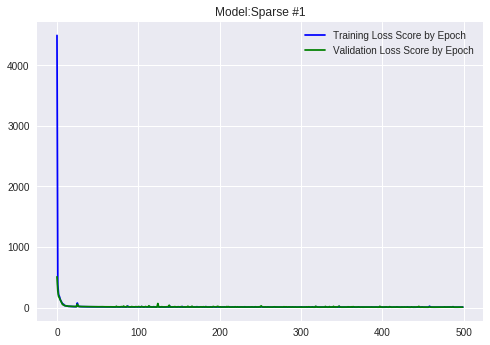

In [124]:
name = 'Model:Sparse #1'
plot_loss(name, sparse_1_history)

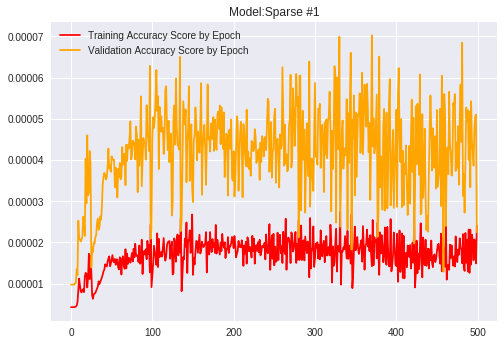

In [126]:
plot_accuracy(name, sparse_1_history)

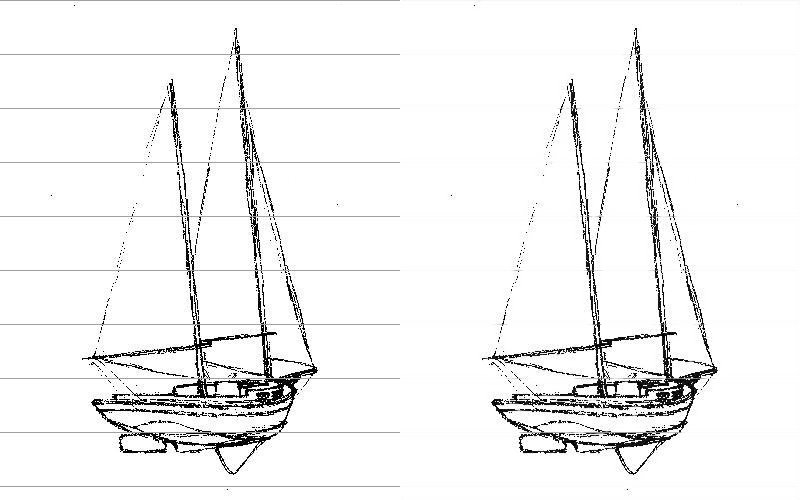

In [127]:
predict_image_on_X(sparse_1)

In [11]:
file_paths = ['Data/Original_Ruled/IMG_0003.jpg', 'Data/Original_Ruled/IMG_0005.jpg',
              'Data/Original_Ruled/IMG_0008.jpg','Data/Original_Ruled/IMG_0012.jpg',
              'Data/Original_Ruled/IMG_0035.jpg','Data/Original_Ruled/IMG_0042.jpg',
              'Data/Original_Ruled/IMG_0045.jpg','Data/Original_Ruled/IMG_0296.jpg',
              'Data/Original_Ruled/Sketch60s_0095.jpg']
#file_path = 'Data/Original_Ruled/IMG_0003.jpg'
unseen = predict_on_unseen(sparse_1, file_paths)

unseen[0]

NameError: name 'sparse_1' is not defined

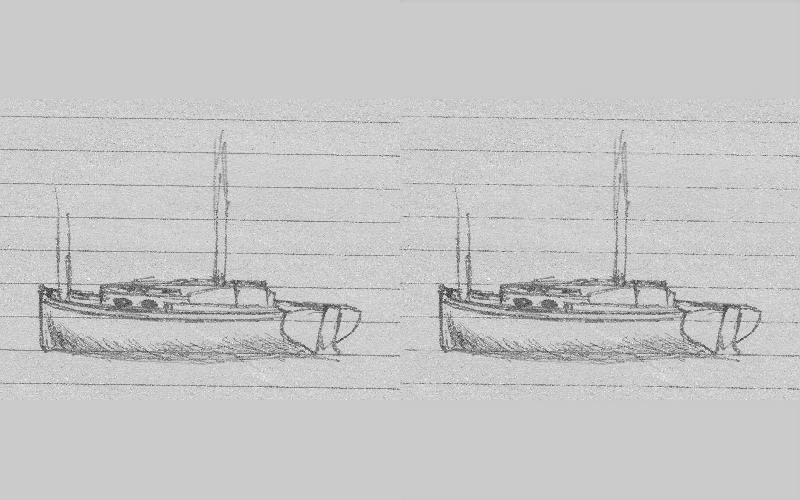

In [129]:
unseen[0]

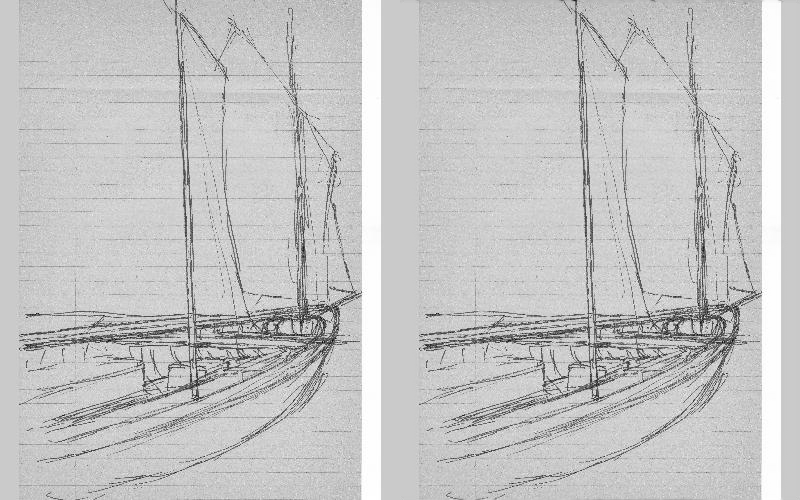

In [130]:
unseen[1]

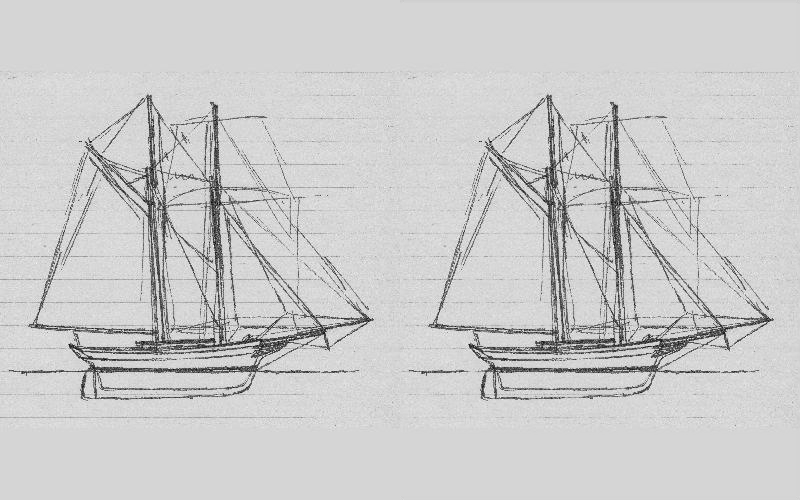

In [131]:
unseen[3]

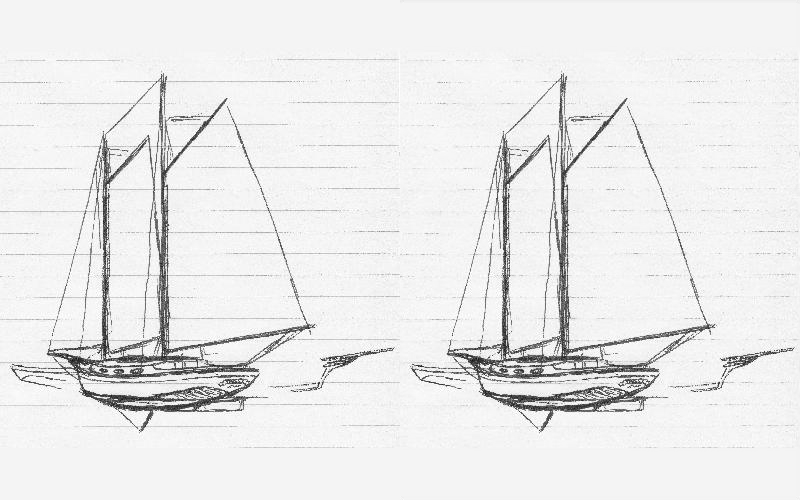

In [132]:
unseen[4]

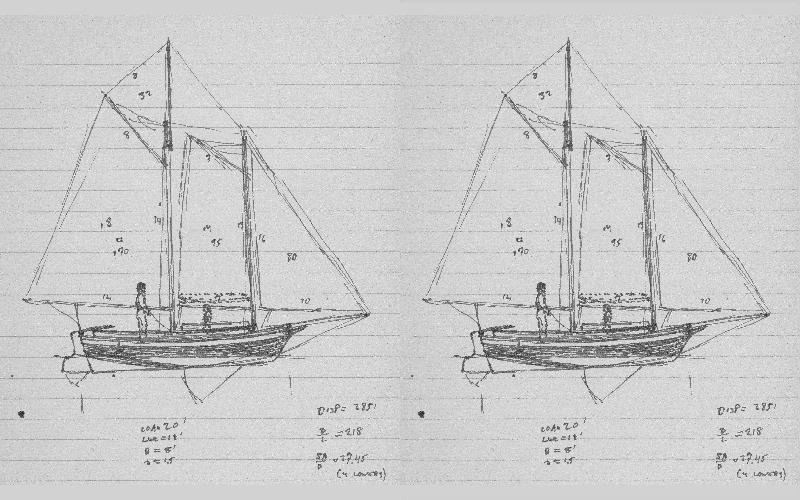

In [133]:
unseen[5]

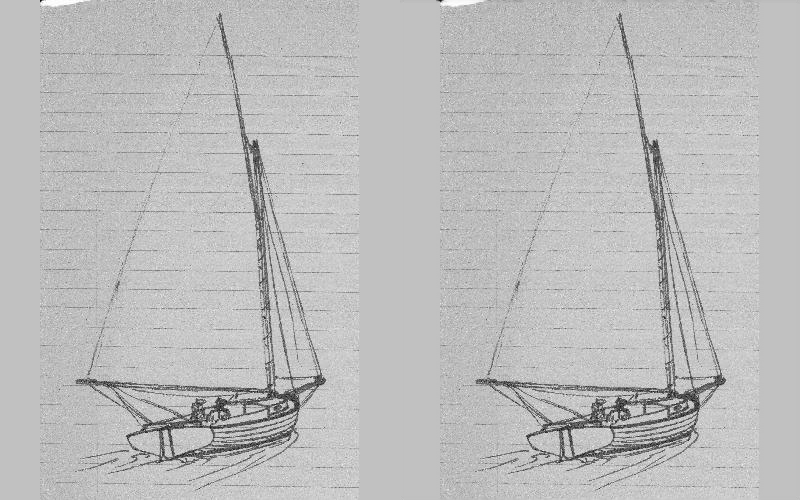

In [136]:
unseen[6]

# next try - save this 'enhanced' figure - then apply this model to the enhanced figure - see results

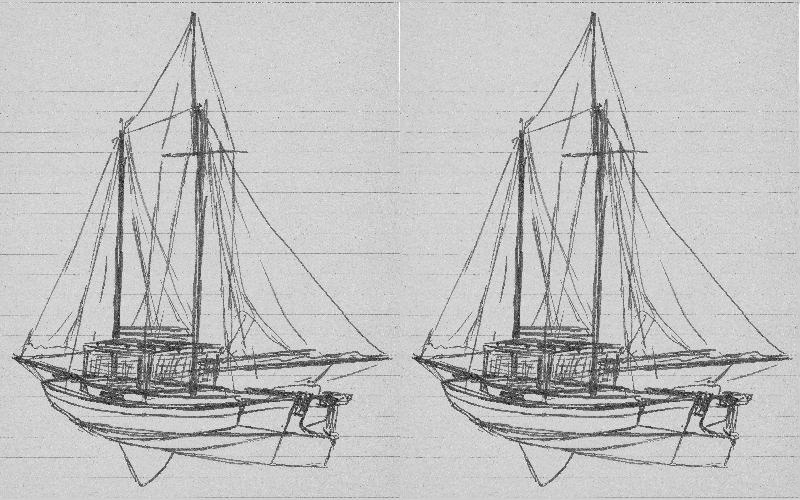

In [135]:
unseen[7]

## Model 2: with callbacks 

In [ ]:
#Model 2 (with callbacks)
tensorboard, early_stopping, model_cp = callbacks(model_name = 'sparse_2', early_stopping = True, patience = None)
sparse_2 = create_and_compile_sparse_model(optimizer='adam', loss='mse', metrics='accuracy')

In [ ]:
sparse_2_history = fit_model(sparse_2, x=X, y=y, batch_size=15, epochs=500, verbose=1, 
                             callbacks=[tensorboard, model_cp], 
                             validation_split=0.2)

In [ ]:
plot_accuracy(sparse_2_history), plot_loss(sparse_2_history)

In [ ]:
predict_image_on_X(sparse_2)

In [ ]:
unseen = predict_on_unseen(sparse_2, file_paths)

JUNK BELOW THIS LINE:

In [ ]:
image_to_predict = np.array(Image.open('Data/Original_Ruled/IMG_0003.jpg'))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

ax[0].imshow(scharr)
ax[0].set_title('Scharr')
ax[0].axis('off')

ax[1].imshow(scharr_h)
ax[1].set_title('Scharr Horizontal')
ax[1].axis('off')

ax[2].imshow(scharr_v)
ax[2].set_title('Scharr Vertical')
ax[2].axis('off')
